### Running a GLM using a `poisson` distribution 

In [1]:
## Adding code from the pymc3 documentation

%matplotlib inline
import sys
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import seaborn as sns
import patsy as pt
import pymc3 as pm

plt.rcParams['figure.figsize'] = 14, 6
np.random.seed(0)
print('Running on PyMC3 v{}'.format(pm.__version__))

/home/vr2352/miniconda/lib/python3.6/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/vr2352/miniconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Running on PyMC3 v3.3


#### Adding Local functions (based on the example code)

In [2]:
def strip_derived_rvs(rvs):
    '''Convenience fn: remove PyMC3-generated RVs from a list'''
    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)
    return ret_rvs


def plot_traces_pymc(trcs, varnames=None):
    ''' Convenience fn: plot traces with overlaid means and values '''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)

    ax = pm.traceplot(trcs, varnames=varnames, figsize=(12,nrows*1.4),
                      lines={k: v['mean'] for k, v in
                             pm.summary(trcs,varnames=varnames).iterrows()})

    for i, mn in enumerate(pm.summary(trcs, varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022')

### Generating some data

In this assignment, I will be using a `poisson` distribution to identify the detectability of a species, given the presence/absence of a particular species along and not along an elevational gradient. 

In [3]:
# decide poisson theta values

theta_nospecies_elevation = 45    # absence, elevational gradient
theta_species_elevation = 203      # presence, elevational gradient
theta_nospecies_noelevation = 17  # absence, not along an elevational gradient
theta_species_noelevation = 150   # , no antihist

# create samples
q = 1000
df = pd.DataFrame({
        'detectability': np.concatenate((np.random.poisson(theta_nospecies_elevation, q),
                                   np.random.poisson(theta_species_elevation, q),
                                   np.random.poisson(theta_nospecies_noelevation, q),
                                   np.random.poisson(theta_species_noelevation, q))),
        'species': np.concatenate((np.repeat(False, q),
                                   np.repeat(True, q),
                                   np.repeat(False, q),
                                   np.repeat(True, q))),
        'elevation': np.concatenate((np.repeat(False, q),
                                      np.repeat(False, q),
                                      np.repeat(True, q),
                                      np.repeat(True, q)))})

In [4]:
df.tail()

,detectability,elevation,species
3995,142,True,True
3996,152,True,True
3997,153,True,True
3998,147,True,True
3999,144,True,True


View the means of the various combinations (Poisson mean values)

In [5]:
df.groupby(['species','elevation']).mean().unstack()

detectability         
elevation         False    True 
species                         
False            45.025   16.842
True            202.792  149.950

Describing the dataset

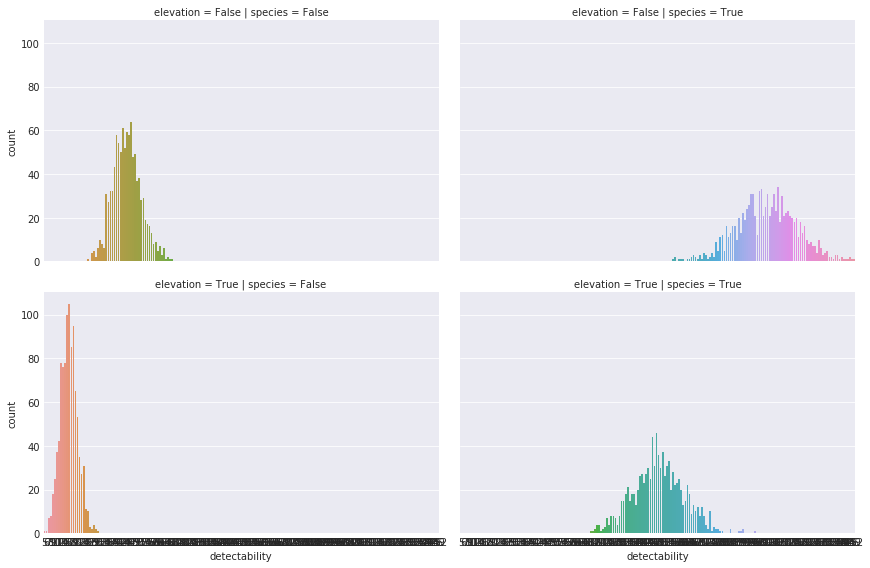

In [6]:
g = sns.factorplot(x='detectability', row='elevation', col='species', data=df,
               kind='count', size=4, aspect=1.5)

## Creating a linear model depicting interaction of terms

In [7]:
fml = 'detectability ~ species + elevation + species:elevation'

### Running a model with `pymc.glm`

In [8]:
with pm.Model() as spm_model:

    pm.glm.GLM.from_formula(fml, df, family=pm.glm.families.Poisson())

In [14]:
with spm_model:
    spec_elev = pm.sample(10)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/vr2352/miniconda/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__, species[T.True]:elevation[T.True], elevation[T.True], species[T.True], Intercept]
 21%|██▏       | 109/510 [18:17<1:07:16, 10.07s/it]/home/vr2352/miniconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)



KeyboardInterrupt: 